# SCICoNE
Here we will use the Python wrapper to facilitate plotting, and use the `verbose=True` flag to print out the corresponding command line calls to the compiled C++ program. Running this tutorial on a common laptop should take 5 to 10 minutes.

In [1]:
import scicone

install_path = '../build/'
temporary_outpath = './'
seed = 42 # for reproducibility

In [2]:
# Create SCICoNE object
sci = scicone.SCICoNE(install_path, temporary_outpath, verbose=True)

Using binaries at ../build/


Let's `simulate_data` with 200 cells, 1000 genomic bins and 10000 reads per cell, corresponding to an average coverage of 10 reads per bin, which is similar to the current 10x Genomics CNV platform. We set `nu=10.0` for moderate data overdispersion.

In [3]:
sim = sci.simulate_data(n_cells=200, n_nodes=5, n_bins=1000, n_regions=10,
                        n_reads=10000, nu=10.0, ploidy=2, seed=seed)

../build/simulation --n_cells=200 --n_nodes=5 --n_regions=10 --n_bins=1000 --n_reads=10000 --nu=10.0 --min_reg_size=10 --max_regions_per_node=1 --ploidy=2 --verbosity=1 --postfix=PYSCICONETEMP --region_neutral_states_file= --seed=42


The output dictionary contains the counts matrix `d_mat`, the true CNVs `ground_truth`, the region sizes `region_sizes` and the underlying true `tree`.

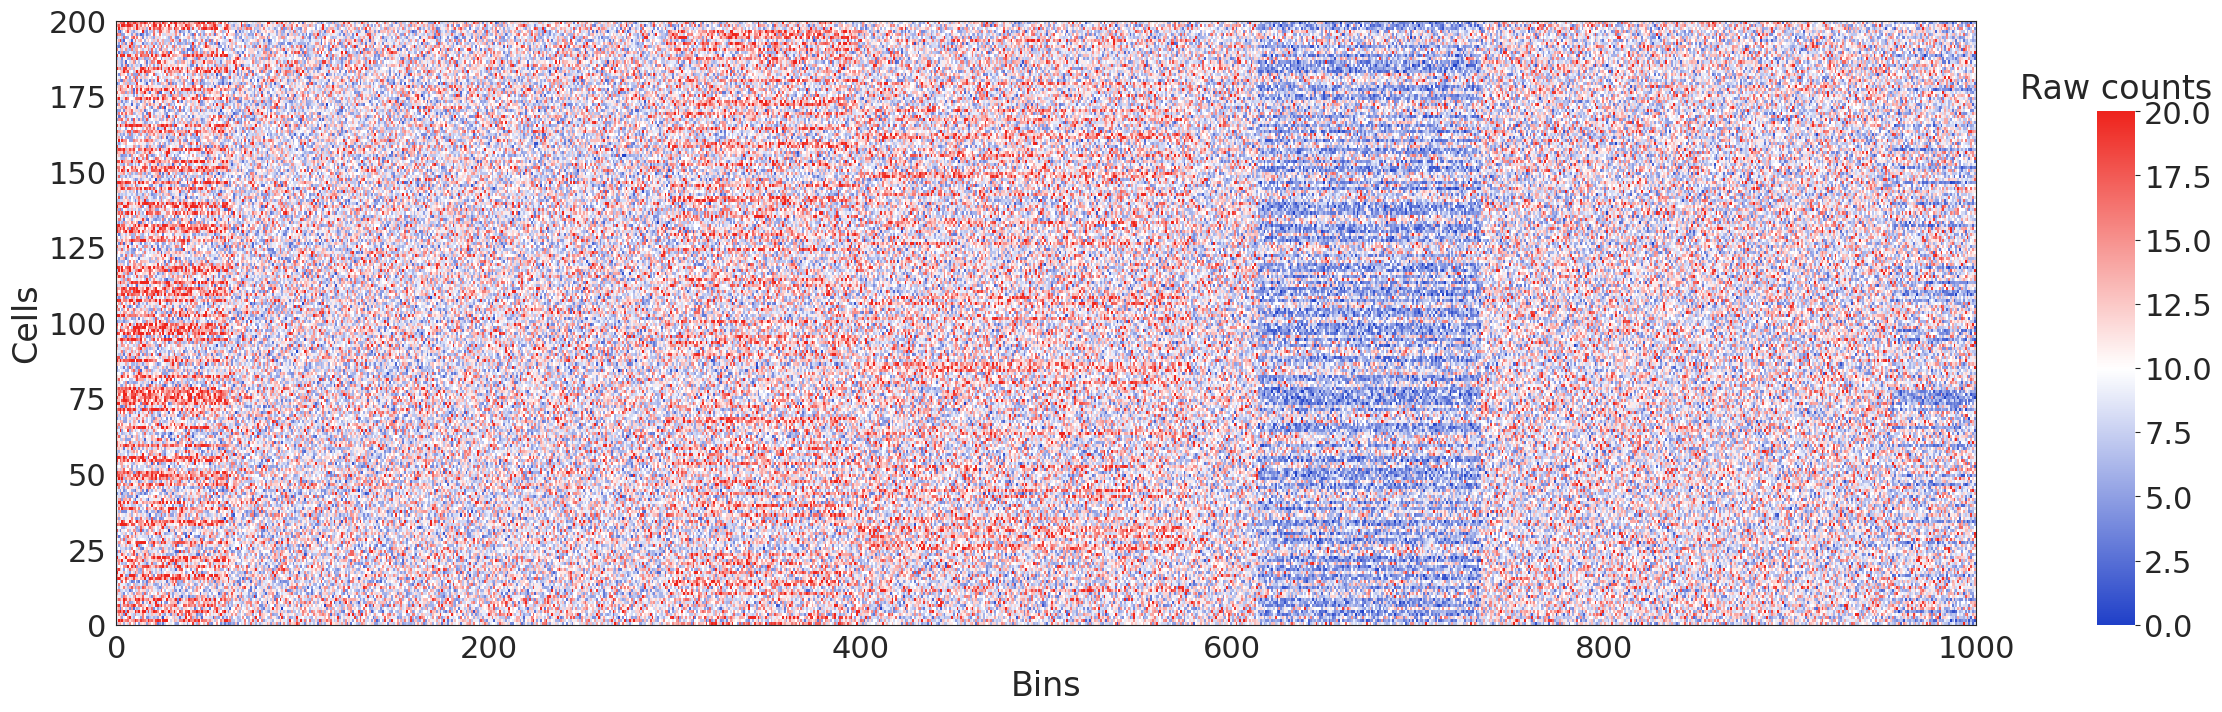

In [4]:
scicone.plotting.plot_matrix(sim['d_mat'], cbar_title='Raw counts', vmax=20)

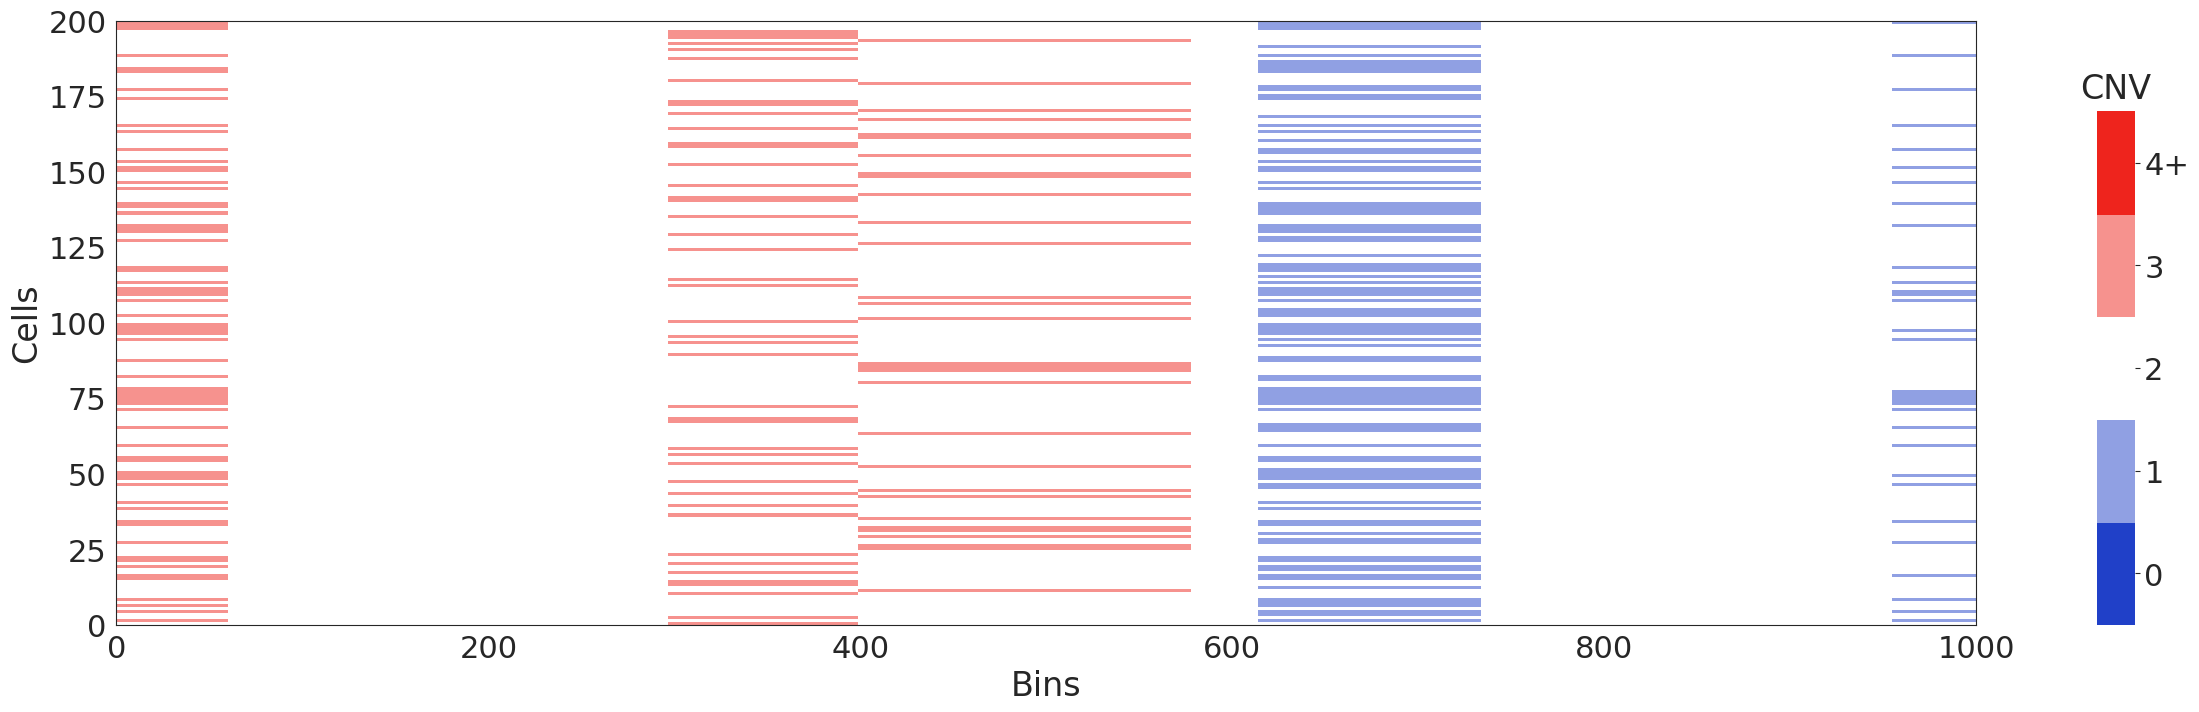

In [5]:
scicone.plotting.plot_matrix(sim['ground_truth'], mode='cnv', cbar_title='CNV')

The first step is to find the breakpoints that define copy number regions using the `breakpoint_detection` binary. The `threshold` parameter controls the sensitivity of the algorithm: lower thresholds lead to more bins being called as breakpoints and vice-versa. In general, detecting more breakpoints than needed is not a problem, since they can be eliminated during the tree inference.

In [6]:
bps = sci.detect_breakpoints(sim['d_mat'], threshold=6.0)

../build/breakpoint_detection --d_matrix_file=PYSCICONETEMPbp_bp_detection.txt --n_bins=1000 --n_cells=200 --window_size=30 --threshold=6.0 --bp_limit=300 --bp_min=0 --compute_lr=True --lr_file= --compute_sp=True --sp_file= --verbosity=1 --evaluate_peaks=True --postfix=PYSCICONETEMPbp --input_breakpoints_file=


The bin indices corresponding the detected breakpoints are stored in `bps['segmented_regions']`. We can check their accuracy by plotting them over the data matrix:

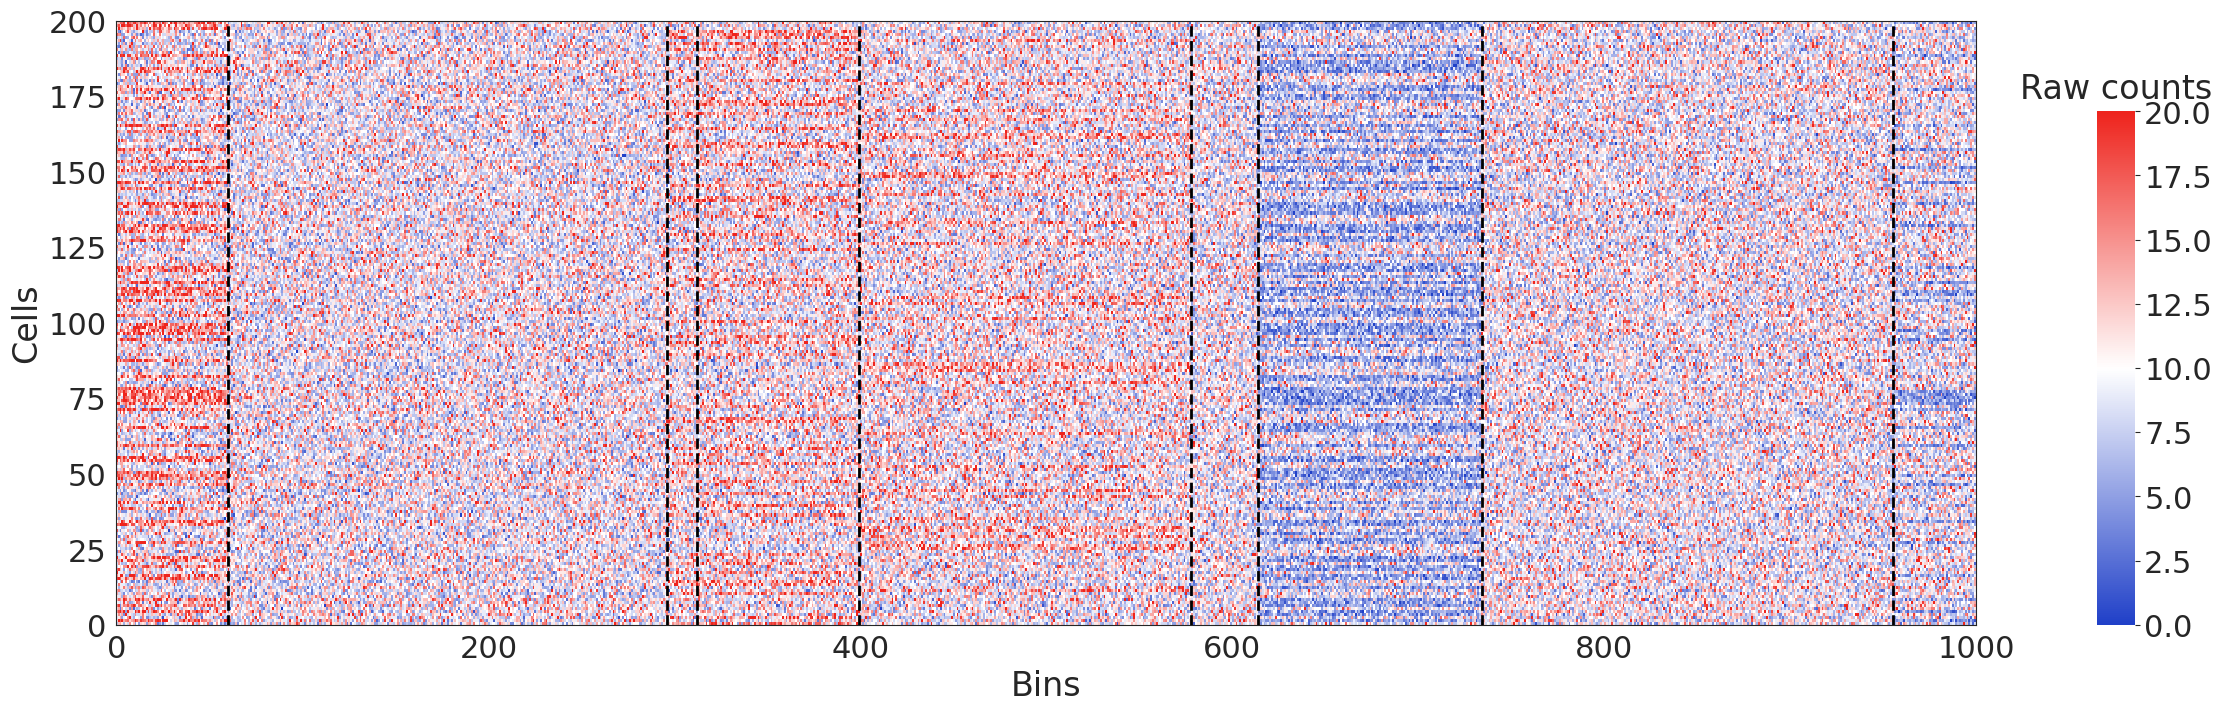

In [7]:
scicone.plotting.plot_matrix(sim['d_mat'], bps=bps['segmented_regions'], cbar_title='Raw counts', vmax=20)

We have recovered the true breakpoints, so now we can run `inference` to simultaneously find the CNV of each cell and the underlying mutation tree. By default, this will first find a tree on the clustered data, and then use that tree as a starting point for the tree search in the full data. Additionally, it uses Python's `multiprocessing` module to run multiple searches in parallel, stores the final trees in the `SCICoNE` object and outputs the highest scoring tree.

In [8]:
inferred_tree = sci.learn_tree(sim['d_mat'], bps['segmented_region_sizes'], n_reps=4, seed=seed)

Condensing regions...
Done.
Learning cluster tree...
n_neighbours to be used: 20
Setting min_cluster_size to 1
Finding 20 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.004499912261962891 seconds
Jaccard graph constructed in 0.02758502960205078 seconds
Wrote graph to binary file in 0.002712249755859375 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.832903
Louvain completed 21 runs in 0.3447306156158447 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 0.8103170394897461 seconds
Found 6 clusters.
Cluster sizes: [44. 35. 32. 31. 30. 28.]
../build/inference --d_matrix_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=9 --n_cells=6 --ploidy=2 --verbosity=1 --postfix=rep0_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=42 --region_sizes_file=rep0_

The parameters for the best tree (like the inferred CNVs and other information related to its MCMC run) are available at `inferred_tree.outputs`. We use the `labels` keyword argument of the `plot_matrix` function to group cells belonging to the same clone together.

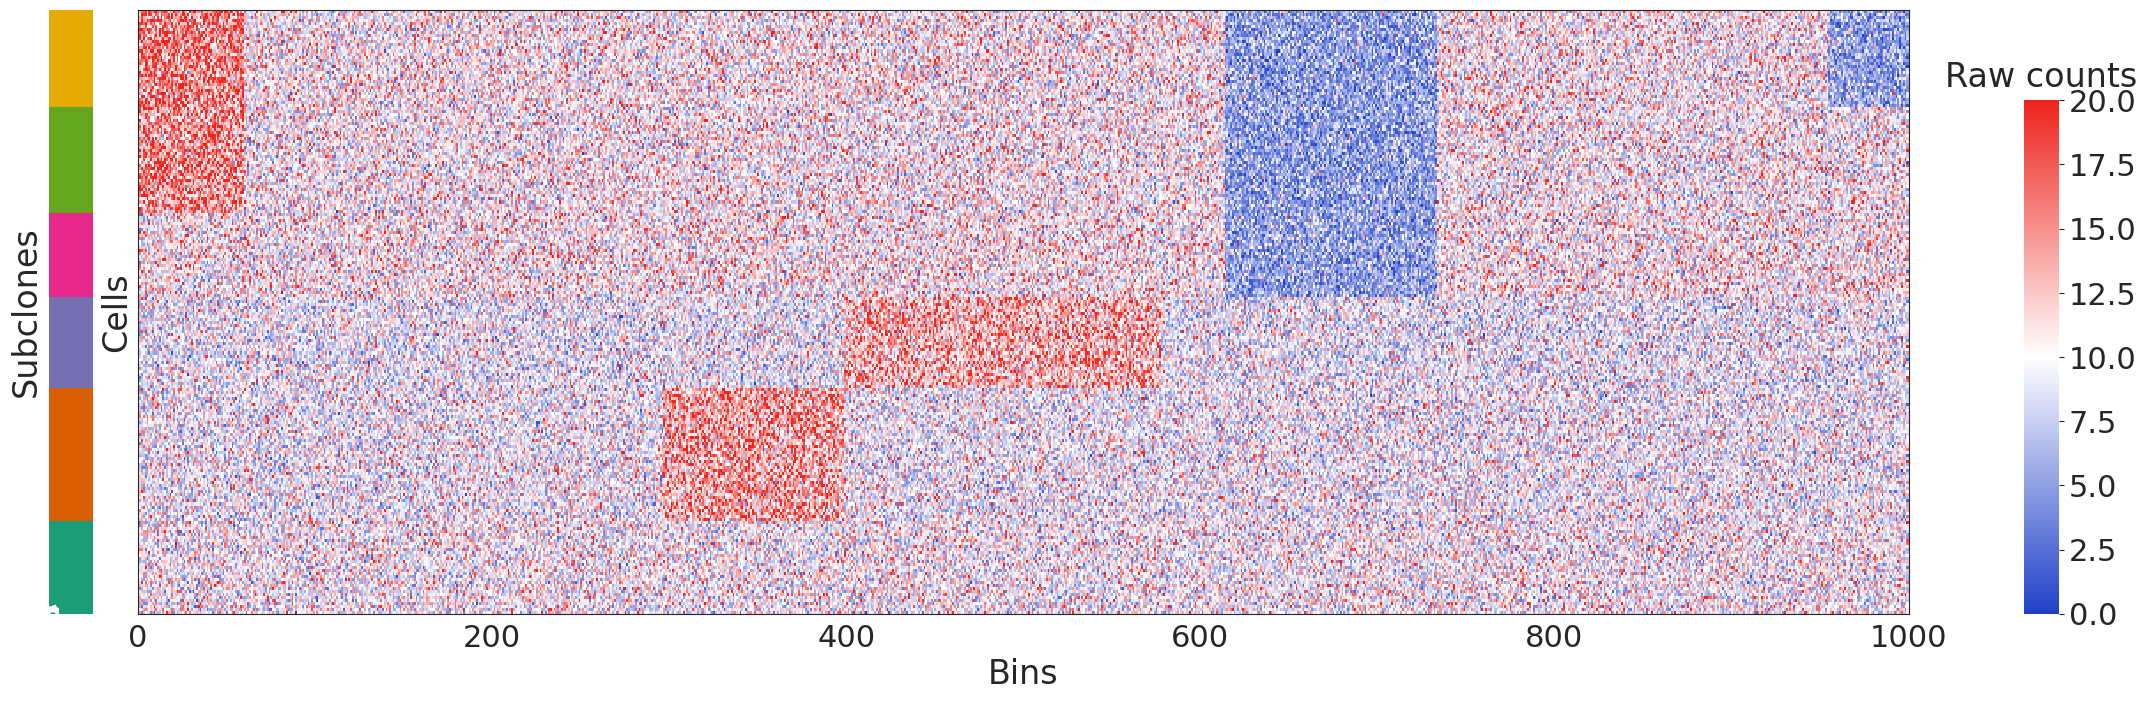

In [9]:
scicone.plotting.plot_matrix(sim['d_mat'], mode='data', cbar_title='Raw counts', vmax=20,
                            labels=inferred_tree.cell_node_labels)

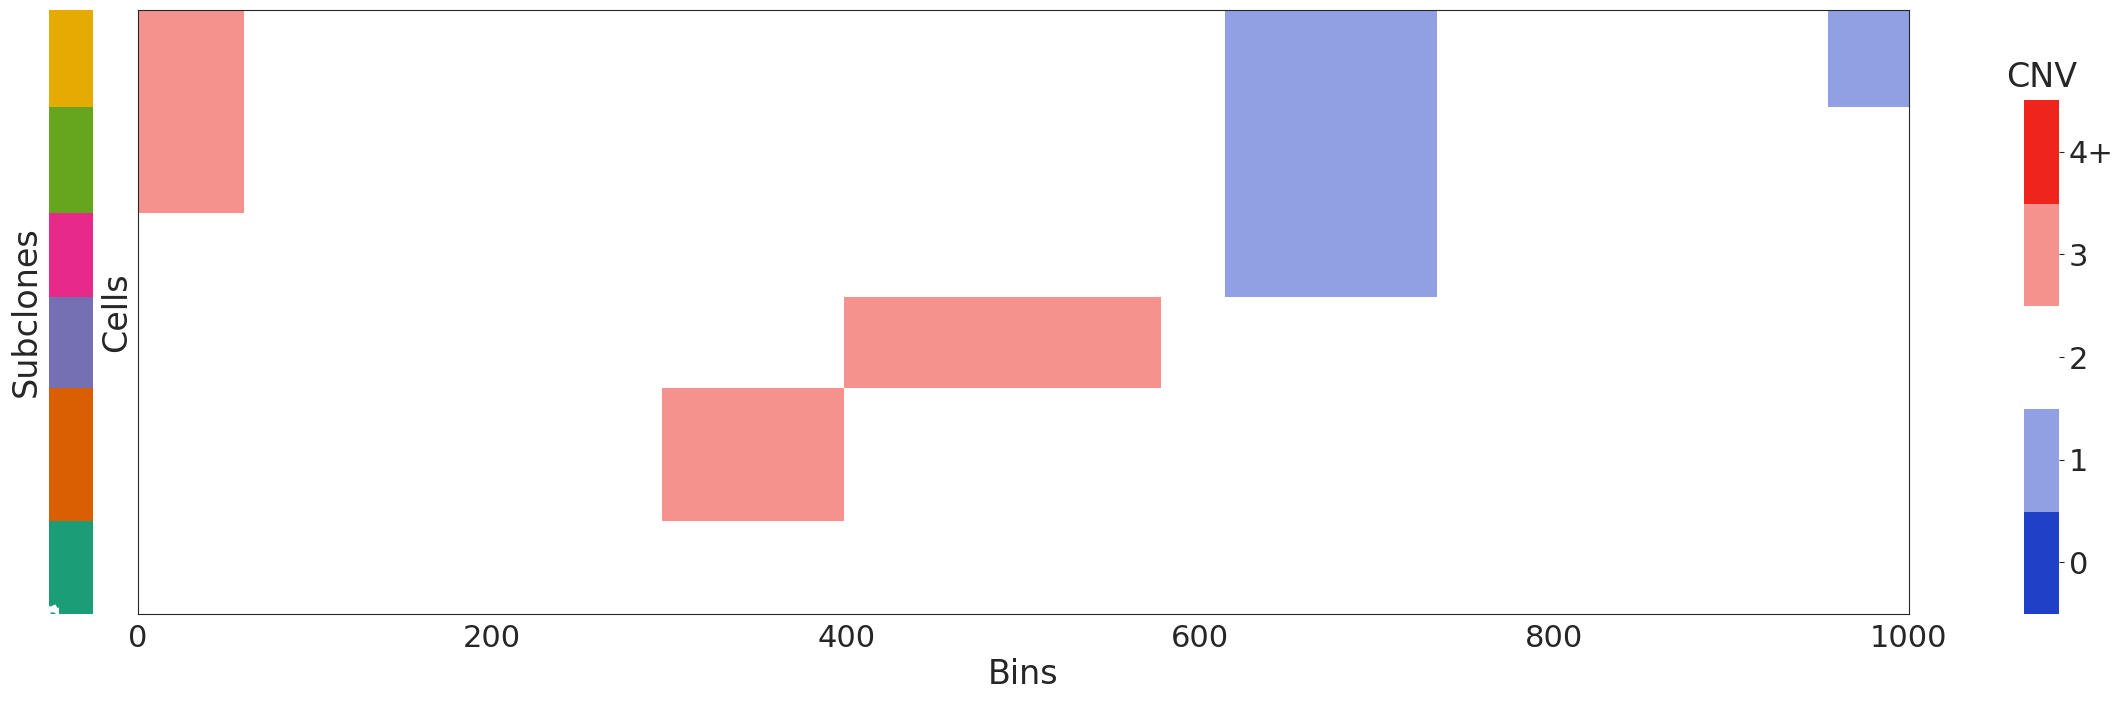

In [10]:
scicone.plotting.plot_matrix(inferred_tree.outputs['inferred_cnvs'], mode='cnv', cbar_title='CNV',
                            labels=inferred_tree.cell_node_labels)

And the inferred tree can be plotted using `plot_tree()`, where each node is labeled by the copy number changes ocurring in the cells attached to it:

In [12]:
itree=inferred_tree.plot_tree(node_labels=True, node_sizes=False)

In [16]:
itree.save("itree")

'itree.gv'

For more information on how to use SCICoNE, including examples for running on data from the 10x Genomics CNV pipeline and integration with `snakemake`, please visit https://github.com/cbg-ethz/SCICoNE/.